### Imports

In [1]:
import pandas as pd
from scipy import stats
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import sklearn.linear_model as lm
from sklearn.metrics import r2_score, accuracy_score, mean_squared_error, confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns


### Funções

In [2]:
def load_data(file_path):
    return pd.read_parquet(file_path)

def df_summary(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Column'] = summary['index']
    summary = summary[['Column','dtypes']]
    summary['# Missing'] = df.isnull().sum().values
    summary['# Unique'] = df.nunique().values
    summary['Example'] = df.loc[0].values

    for name in summary['Column'].value_counts().index:
        summary.loc[summary['Column'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2)

    return summary

def create_classification_report_df(class_reports,model_names):
    if len(class_reports) != len(model_names):
        raise ValueError("O número de relatórios de classificação deve ser igual ao número de nomes de modelos.")

    all_reports = []

    for report, model_name in zip(class_reports, model_names):
        # Verificar se as chaves esperadas existem no relatório
        data = {
            'Model': model_name,
            'Accuracy': report.get('accuracy', None),
            'Class 0 Precision': report.get('0', {}).get('precision', None),
            'Class 0 Recall': report.get('0', {}).get('recall', None),
            'Class 0 F1-Score': report.get('0', {}).get('f1-score', None),
            'Class 1 Precision': report.get('1', {}).get('precision', None),
            'Class 1 Recall': report.get('1', {}).get('recall', None),
            'Class 1 F1-Score': report.get('1', {}).get('f1-score', None),
            'Class 2 Precision': report.get('2', {}).get('precision', None),
            'Class 2 Recall': report.get('2', {}).get('recall', None),
            'Class 2 F1-Score': report.get('2', {}).get('f1-score', None),
            'Macro Avg Precision': report.get('macro avg', {}).get('precision', None),
            'Macro Avg Recall': report.get('macro avg', {}).get('recall', None),
            'Macro Avg F1-Score': report.get('macro avg', {}).get('f1-score', None),
            'Weighted Avg Precision': report.get('weighted avg', {}).get('precision', None),
            'Weighted Avg Recall': report.get('weighted avg', {}).get('recall', None),
            'Weighted Avg F1-Score': report.get('weighted avg', {}).get('f1-score', None)
        }
        all_reports.append(data)

    return pd.DataFrame(all_reports)
def evaluate_feature_importance(model, x_train, x_test, y_train, y_test):
    accuracies = []
    features = x_train.columns
    for feature in features:
        x_train_temp = x_train.drop(columns=[feature])
        x_test_temp = x_test.drop(columns=[feature])
        model.fit(x_train_temp, y_train)
        y_pred_temp = model.predict(x_test_temp)
        accuracy = accuracy_score(y_test, y_pred_temp)
        accuracies.append((feature, accuracy))
    return accuracies

def evaluate_model(model, x_train, x_test, y_train, y_test):
    """
    Avalia um modelo e retorna as métricas de desempenho para treino e teste.

    Args:
        model: O modelo a ser avaliado.
        x_train: Dados de treino.
        x_test: Dados de teste.
        y_train: Rótulos de treino.
        y_test: Rótulos de teste.

    Returns:
        Um dicionário com as métricas de desempenho.
    """

    y_pred_train = model.predict(x_train)
    y_pred_test = model.predict(x_test)

    metrics = {
        'train': {
            'accuracy': accuracy_score(y_train, y_pred_train),
            'precision': precision_score(y_train, y_pred_train, average='macro'),
            'recall': recall_score(y_train, y_pred_train, average='macro'),
            'f1': f1_score(y_train, y_pred_train, average='macro')
        },
        'test': {
            'accuracy': accuracy_score(y_test, y_pred_test),
            'precision': precision_score(y_test, y_pred_test, average='macro'),
            'recall': recall_score(y_test, y_pred_test, average='macro'),
            'f1': f1_score(y_test, y_pred_test, average='macro')
        }
    }

    return metrics



### Carregando dados

In [3]:
seed = 42
file_path = '../data/outputs/costumers_feature_df.parquet'
file_path2 = '../data/outputs/feature_df.parquet'
file_path3 = '../data/outputs/finale_df.parquet'
df = load_data(file_path3)
##display(df)

rating = df['review_score_factor']
#rating = df['review_score']

drop_columns = ['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', \
                'order_delivered_customer_date', 'order_estimated_delivery_date', 'review_id', 'review_comment_title', 'review_score', \
                'review_creation_date', 'review_comment_message', 'review_answer_timestamp', 'payment_sequential', 'payment_type', 'customer_unique_id', \
                'customer_zip_code_prefix', 'customer_city', 'customer_state', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', \
                'freight_value', 'product_category_name', 'product_length_cm', 'product_height_cm', 'product_width_cm', \
                'seller_zip_code_prefix', 'seller_city', 'seller_state', 'review_score_factor','satisfaction']

features = df.drop(drop_columns, axis=1)
features = features.fillna(features.mean())

In [4]:
features.head()

,payment_installments,payment_value,product_name_length,product_description_length,product_photos_qty,product_weight_g,comp_score,neg,pos,neu,polarity,price_factor,freight_value_factor,if_delivered,actual_est_delivery_diff,delivery_duration,delivery_time_diff,delivery
0,1,18.12,40.0,268.0,4.0,500.0,0.5023,0.126,0.193,0.681,1,0.0,0.0,1.0,7.0,8.0,-8.0,1
1,1,2.00,40.0,268.0,4.0,500.0,0.5023,0.126,0.193,0.681,1,0.0,0.0,1.0,7.0,8.0,-8.0,1
2,1,18.59,40.0,268.0,4.0,500.0,0.5023,0.126,0.193,0.681,1,0.0,0.0,1.0,7.0,8.0,-8.0,1
3,3,37.77,40.0,268.0,4.0,500.0,0.7003,0.000,0.367,0.633,1,0.0,0.0,1.0,9.0,2.0,-10.0,1
4,1,37.77,40.0,268.0,4.0,500.0,0.4215,0.000,0.219,0.781,1,0.0,0.0,1.0,7.0,5.0,-8.0,1


### Dividindo os dados

In [5]:

x_train, x_test, y_train, y_test = train_test_split(features, rating, test_size = 0.2, random_state = seed)

### Criação e treinamento do modelo de XGBoost

c:\Users\mater\Documents\Projetos git\Olist-Brazilian-E-Commerce\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:10:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Model
Accuracy: 0.702909493607168
Classification Report:
{'0.0': {'precision': 0.7221345121566151, 'recall': 0.7954782608695652, 'f1-score': 0.7570340946706389, 'support': 2875.0}, '1.0': {'precision': 0.5529841656516443, 'recall': 0.1952688172043011, 'f1-score': 0.28862047043865224, 'support': 2325.0}, '2.0': {'precision': 0.7133725820016821, 'recall': 0.8960490175364463, 'f1-score': 0.7943435100206031, 'support': 4733.0}, 'accuracy': 0.702909493607168, 'macro avg': {'precision': 0.6628304199366472, 'recall': 0.6289320318701042, 'f1-score': 0.6133326917099647, 'support': 9933.0}, 'weighted avg': {'precision': 0.6783667913222895, 'recall': 0.702909493607168, 'f1-score': 0.6651709905240579, 'support': 9933.0}}


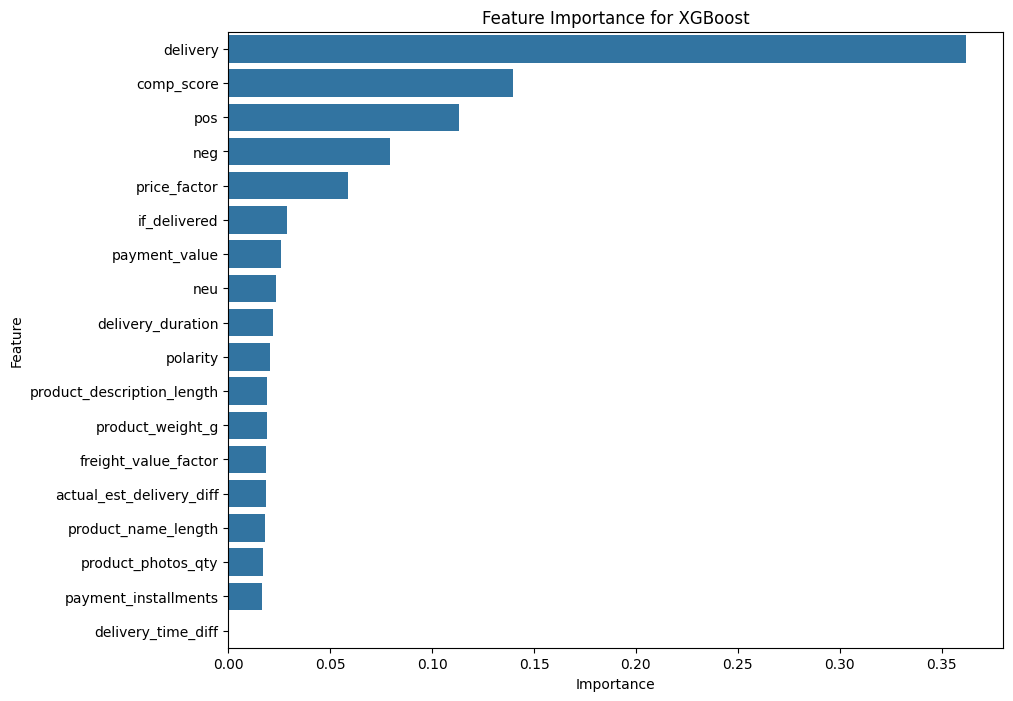

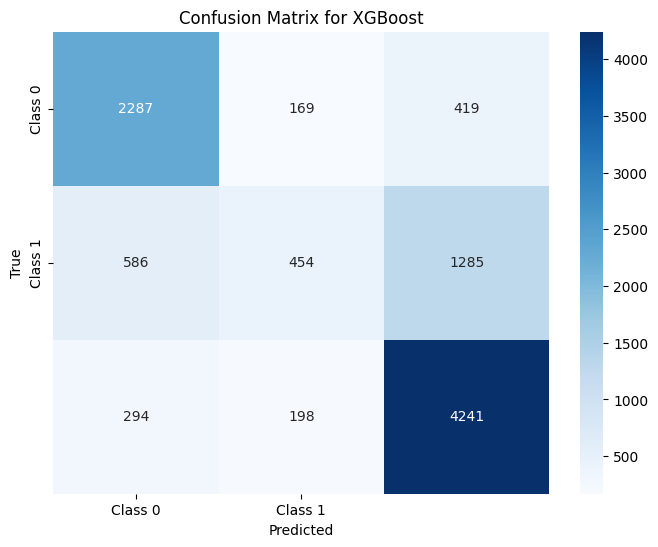

In [6]:
# Initialize XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Fit model
xgb_model.fit(x_train, y_train)

# Make predictions
y_pred = xgb_model.predict(x_test)

# Evaluate model
accuracy_xgb = accuracy_score(y_test, y_pred)
conf_matrix_xgb = confusion_matrix(y_test, y_pred)
class_report_xgb = classification_report(y_test, y_pred, output_dict=True)

print("XGBoost Model")
print(f"Accuracy: {accuracy_xgb}")
print("Classification Report:")
print(class_report_xgb)

# Feature Importance for XGBoost
importance = xgb_model.feature_importances_
features_names = x_train.columns
importance_df = pd.DataFrame({'Feature': features_names, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance for XGBoost')
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix for XGBoost')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Criação e treinamento do modelo de Árvore de decisão

{'0.0': {'precision': 0.7221345121566151, 'recall': 0.7954782608695652, 'f1-score': 0.7570340946706389, 'support': 2875.0}, '1.0': {'precision': 0.5529841656516443, 'recall': 0.1952688172043011, 'f1-score': 0.28862047043865224, 'support': 2325.0}, '2.0': {'precision': 0.7133725820016821, 'recall': 0.8960490175364463, 'f1-score': 0.7943435100206031, 'support': 4733.0}, 'accuracy': 0.702909493607168, 'macro avg': {'precision': 0.6628304199366472, 'recall': 0.6289320318701042, 'f1-score': 0.6133326917099647, 'support': 9933.0}, 'weighted avg': {'precision': 0.6783667913222895, 'recall': 0.702909493607168, 'f1-score': 0.6651709905240579, 'support': 9933.0}}


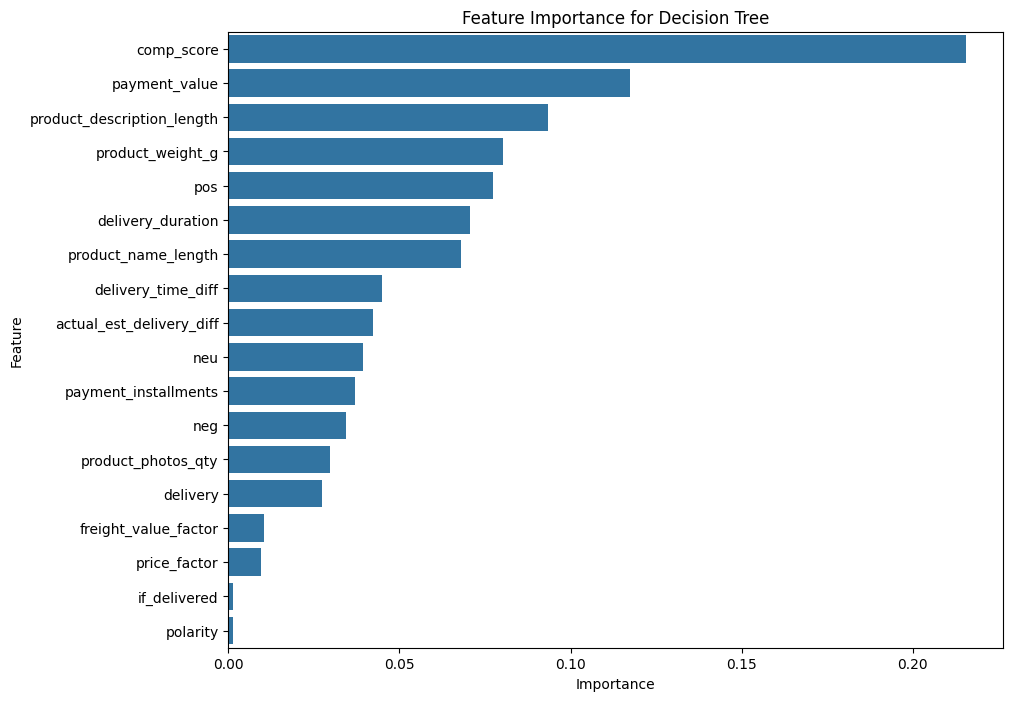

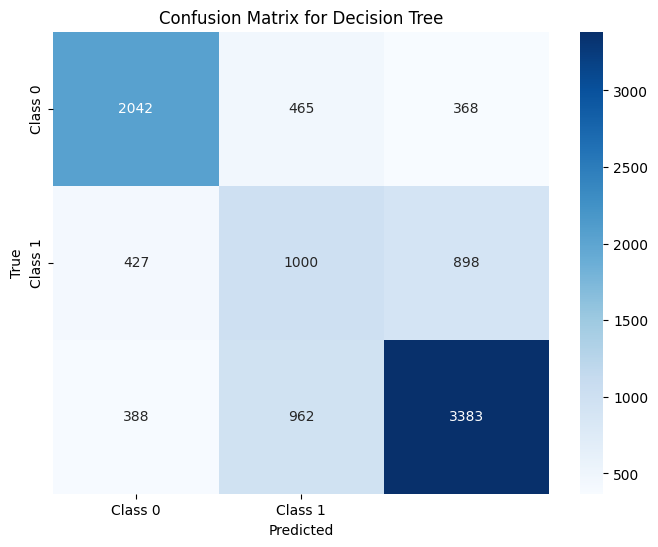

In [7]:
clf = DecisionTreeClassifier(random_state=seed)
clf.fit(x_train, y_train)

# Realização de previsões
y_pred_dt = clf.predict(x_test)

# Avaliação do modelo
accuracy = accuracy_score(y_test, y_pred)
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)
class_report_dt = classification_report(y_test, y_pred,output_dict=True)
print(class_report_dt)

importance_dt = clf.feature_importances_
importance_df_dt = pd.DataFrame({'Feature': features_names, 'Importance': importance_dt})
importance_df_dt = importance_df_dt.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df_dt)
plt.title('Feature Importance for Decision Tree')
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_dt, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix for Decision Tree')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Criação e treinamento do modelo de regressão logística

{'0.0': {'precision': 0.6311373523927906, 'recall': 0.7064347826086956, 'f1-score': 0.6666666666666666, 'support': 2875.0}, '1.0': {'precision': 0.2747603833865815, 'recall': 0.036989247311827955, 'f1-score': 0.06520090978013647, 'support': 2325.0}, '2.0': {'precision': 0.6508903467666354, 'recall': 0.8804141136699768, 'f1-score': 0.748450830713965, 'support': 4733.0}, 'accuracy': 0.632638679150307, 'macro avg': {'precision': 0.5189293608486691, 'recall': 0.5412793811968335, 'f1-score': 0.49343946905358943, 'support': 9933.0}, 'weighted avg': {'precision': 0.5571329699737804, 'recall': 0.632638679150307, 'f1-score': 0.5648521658788563, 'support': 9933.0}}


c:\Users\mater\Documents\Projetos git\Olist-Brazilian-E-Commerce\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


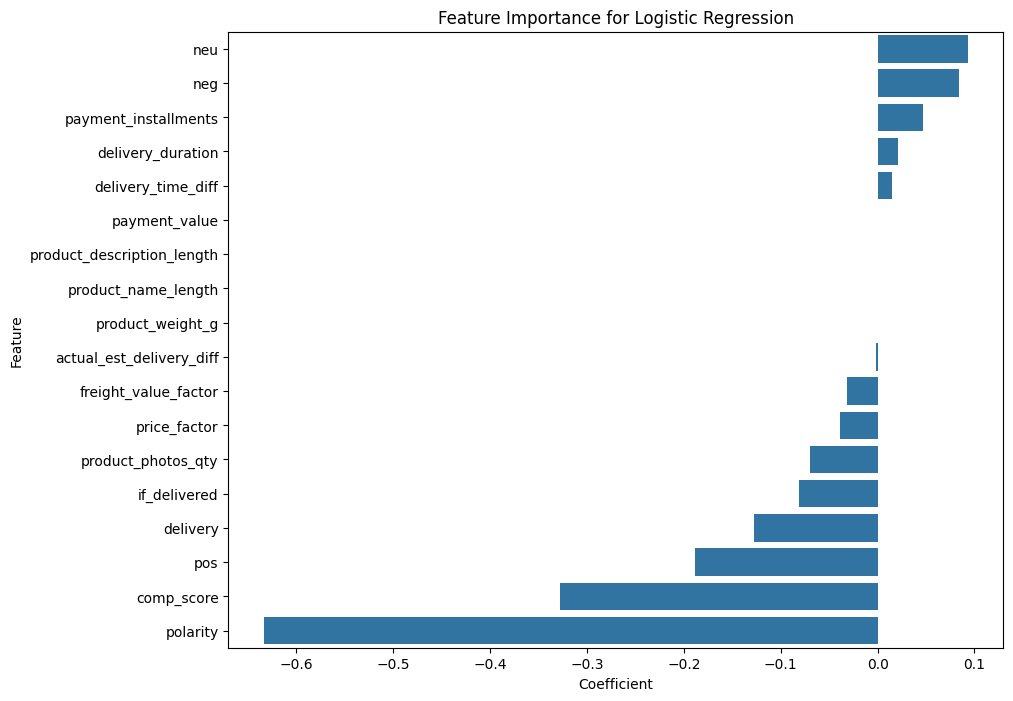

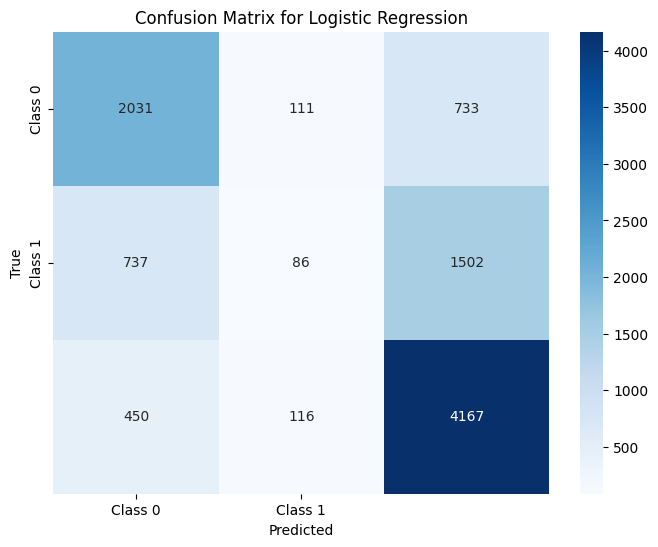

In [8]:
# Criar e treinar o modelo de regressão logística
model = LogisticRegression(max_iter=1000, random_state=seed)
model.fit(x_train, y_train)

# Fazer previsões e avaliar o modelo
y_pred_lr = model.predict(x_test)
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)
class_report_lr = classification_report(y_test, y_pred_lr,output_dict=True)
print(class_report_lr)

coefficients = model.coef_[0]
importance_lr_df = pd.DataFrame({'Feature': features_names, 'Coefficient': coefficients})
importance_lr_df = importance_lr_df.sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Coefficient', y='Feature', data=importance_lr_df)
plt.title('Feature Importance for Logistic Regression')
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lr, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix for Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Criação e treinamento do modelo com regressão linear

In [9]:

reg = lm.LinearRegression().fit(x_train, y_train)

y_pred_lr = reg.predict(x_test)

score = reg.score(x_test, y_test)
rmse_lr = np.sqrt(mean_squared_error(y_test.values, y_pred_lr))

print(f'The R2 score in this linear regression model is {round(score, 5)}')
print(f'The RMSE in this linear regression model is {round(rmse_lr, 5)}, which is about {100*round(rmse_lr/np.mean(rating),2)}% of \
the mean rating score.')

The R2 score in this linear regression model is 0.41028
The RMSE in this linear regression model is 0.65655, which is about 55.00000000000001% of the mean rating score.


### Criação e treinamento do modelo com floresta aleatória

The accuracy of the RF model is 0.75033
Classification Report for Random Forest:
{'0.0': {'precision': 0.7669597989949749, 'recall': 0.8493913043478261, 'f1-score': 0.8060736095065192, 'support': 2875.0}, '1.0': {'precision': 0.6917293233082706, 'recall': 0.31655913978494626, 'f1-score': 0.43434641487164355, 'support': 2325.0}, '2.0': {'precision': 0.7519788918205804, 'recall': 0.9032326220156349, 'f1-score': 0.8206949510462661, 'support': 4733.0}, 'accuracy': 0.7503271921876573, 'macro avg': {'precision': 0.7368893380412752, 'recall': 0.6897276887161358, 'f1-score': 0.6870383251414762, 'support': 9933.0}, 'weighted avg': {'precision': 0.7422124427453024, 'recall': 0.7503271921876573, 'f1-score': 0.7260310324383159, 'support': 9933.0}}


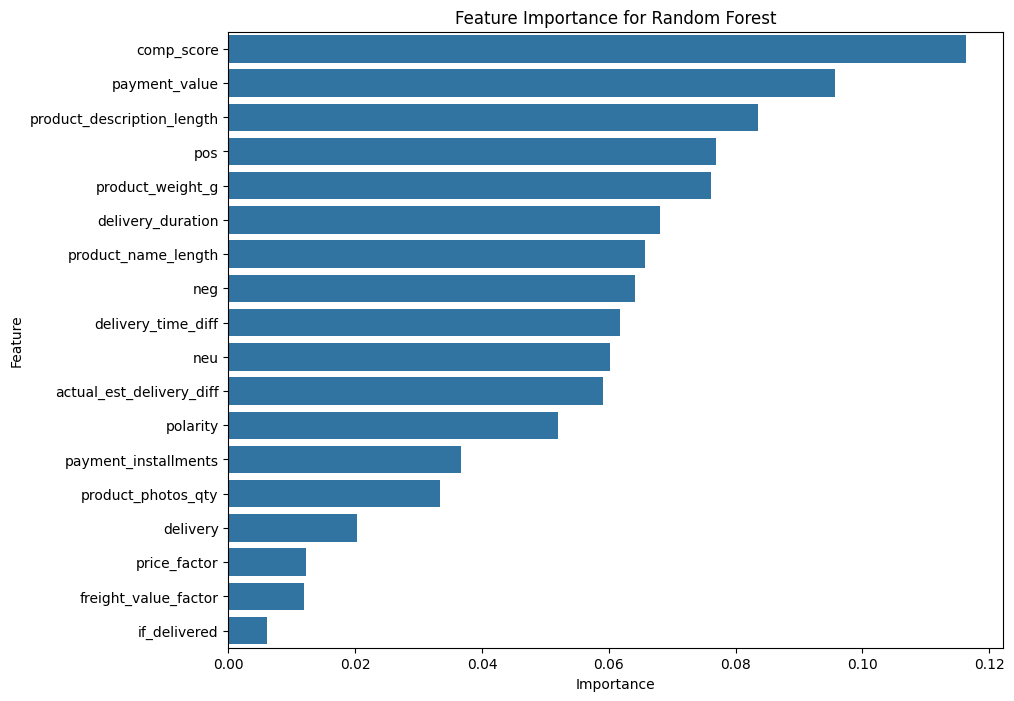

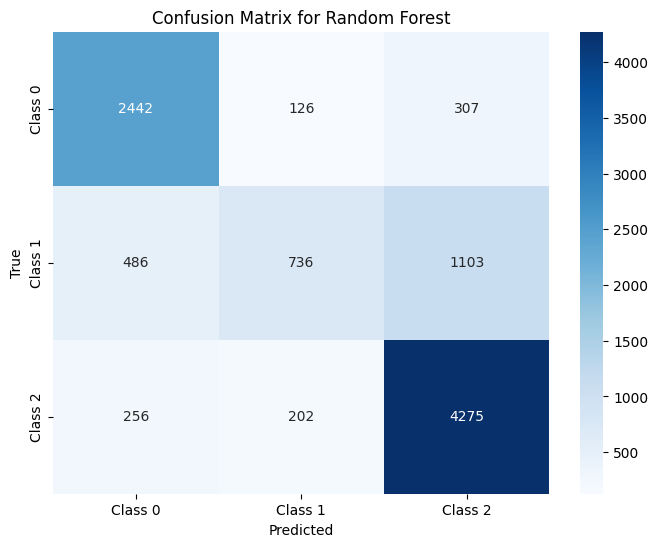

In [10]:
model_rf = RandomForestClassifier(n_estimators=100, random_state=seed)

# Ajuste o modelo com os dados de treinamento
model_rf.fit(x_train, y_train)

# Fazer previsões
y_pred_rf = model_rf.predict(x_test)

# Avaliar o modelo
accuracy_rf = accuracy_score(y_test, y_pred_rf)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
print(f'The accuracy of the RF model is {round(accuracy_rf, 5)}')

# Exibir relatório de classificação
class_report_rf = classification_report(y_test, y_pred_rf, output_dict=True)
print("Classification Report for Random Forest:")
print(class_report_rf)

# Feature Importance for Random Forest
# Certifique-se de que o modelo foi ajustado corretamente antes de acessar 'feature_importances_'
importance_rf = model_rf.feature_importances_
features_names = x_train.columns  # Obtendo os nomes das características

# Criação do DataFrame para importâncias
importance_df_rf = pd.DataFrame({'Feature': features_names, 'Importance': importance_rf})
importance_df_rf = importance_df_rf.sort_values(by='Importance', ascending=False)

# Plotagem da importância das características
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df_rf)
plt.title('Feature Importance for Random Forest')
plt.show()

# Plotagem da matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2'], yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.title('Confusion Matrix for Random Forest')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Criação e treinamento do modelo utilizando KNN

The accuracy of the KNN model is 0.49451
{'0.0': {'precision': 0.4650098103335513, 'recall': 0.4946086956521739, 'f1-score': 0.4793527726276757, 'support': 2875.0}, '1.0': {'precision': 0.3364389233954451, 'recall': 0.27956989247311825, 'f1-score': 0.305379375146817, 'support': 2325.0}, '2.0': {'precision': 0.5745498685009104, 'recall': 0.6000422564969364, 'f1-score': 0.587019429516329, 'support': 4733.0}, 'accuracy': 0.4945132386992852, 'macro avg': {'precision': 0.4586662007433023, 'recall': 0.4580736148740762, 'f1-score': 0.45725052576360725, 'support': 9933.0}, 'weighted avg': {'precision': 0.48711046302407923, 'recall': 0.4945132386992852, 'f1-score': 0.4899334771390016, 'support': 9933.0}}


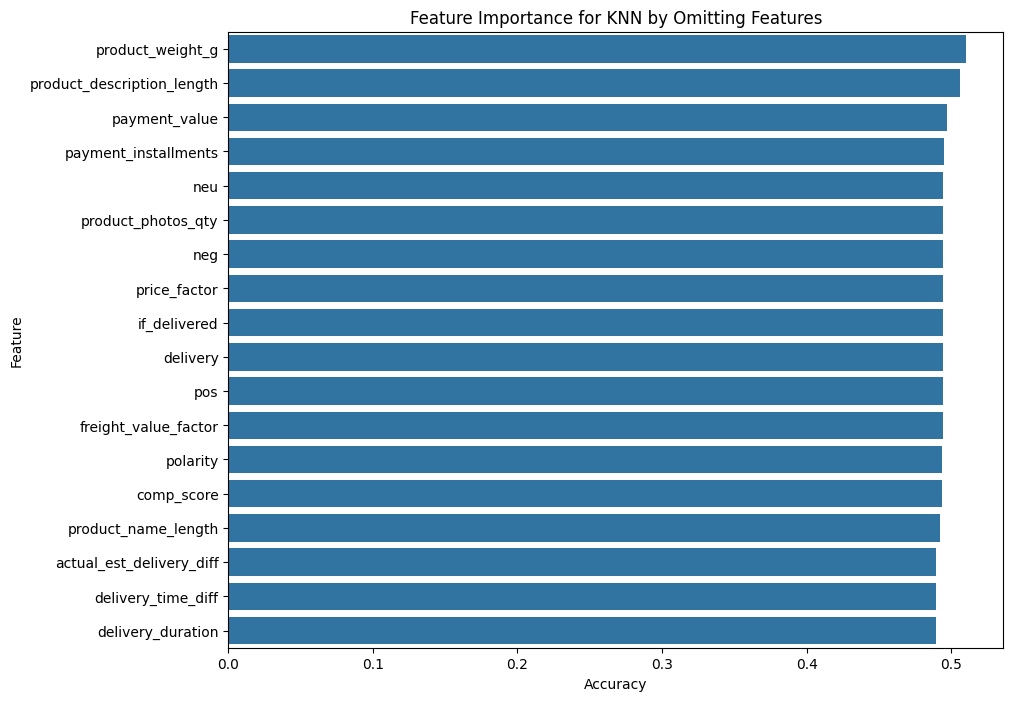

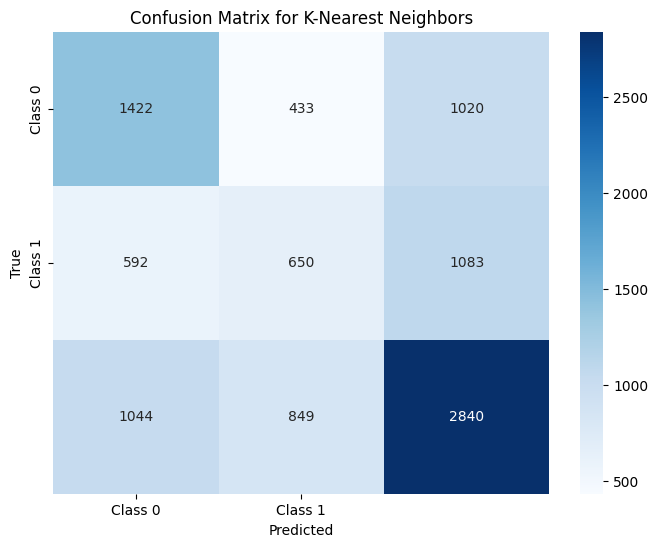

In [11]:
# Criar e treinar o modelo K-Nearest Neighbors
model_knn = KNeighborsClassifier(n_neighbors=5)
model_knn.fit(x_train, y_train)

# Fazer previsões
y_pred_knn = model_knn.predict(x_test)

# Avaliar o modelo
accuracy = accuracy_score(y_test, y_pred_knn)
conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)
print(f'The accuracy of the KNN model is {round(accuracy, 5)}')

# Exibir relatório de classificação
class_report_knn = classification_report(y_test, y_pred_knn,output_dict=True)
print(class_report_knn)

feature_importance_knn = evaluate_feature_importance(model_knn, x_train, x_test, y_train, y_test)
importance_df_knn = pd.DataFrame(feature_importance_knn, columns=['Feature', 'Accuracy'])
importance_df_knn = importance_df_knn.sort_values(by='Accuracy', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Accuracy', y='Feature', data=importance_df_knn)
plt.title('Feature Importance for KNN by Omitting Features')
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_knn, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix for K-Nearest Neighbors')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Criação e treinamento do modelo utilizando GBM

The accuracy of the Gradient Boosting model is 0.6718
{'0.0': {'precision': 0.6830176963675877, 'recall': 0.7652173913043478, 'f1-score': 0.7217847769028871, 'support': 2875.0}, '1.0': {'precision': 0.45114345114345117, 'recall': 0.09333333333333334, 'f1-score': 0.15466856735566642, 'support': 2325.0}, '2.0': {'precision': 0.6830364307494784, 'recall': 0.8992182548066765, 'f1-score': 0.7763589930682233, 'support': 4733.0}, 'accuracy': 0.6718010671499044, 'macro avg': {'precision': 0.6057325260868391, 'recall': 0.5859229931481192, 'f1-score': 0.5509374457755923, 'support': 9933.0}, 'weighted avg': {'precision': 0.628752222662098, 'recall': 0.6718010671499044, 'f1-score': 0.6150450787163623, 'support': 9933.0}}


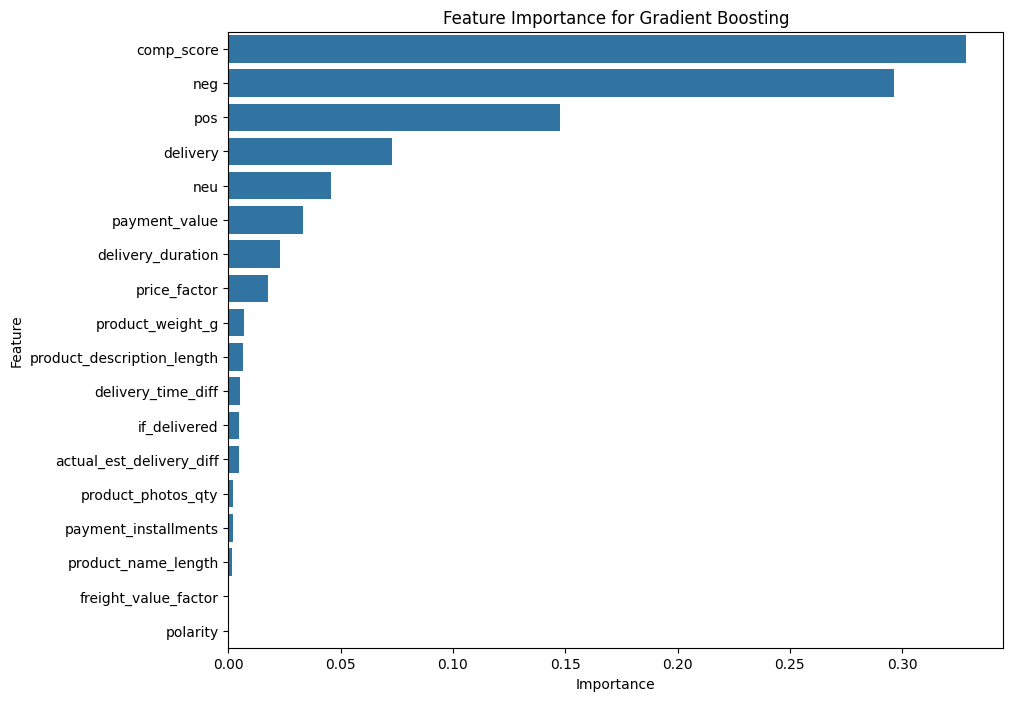

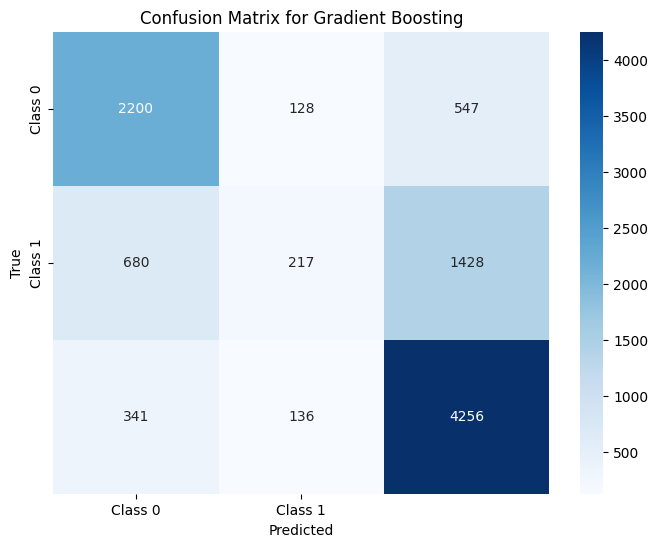

In [12]:
# Criar e treinar o modelo Gradient Boosting
model_gbm = GradientBoostingClassifier(n_estimators=100, random_state=seed)
model_gbm.fit(x_train, y_train)

# Fazer previsões
y_pred_gbm = model_gbm.predict(x_test)

# Avaliar o modelo
accuracy = accuracy_score(y_test, y_pred_gbm)
conf_matrix_gbm = confusion_matrix(y_test, y_pred_gbm)
print(f'The accuracy of the Gradient Boosting model is {round(accuracy, 5)}')

# Exibir relatório de classificação
class_report_gbm = classification_report(y_test, y_pred_gbm,output_dict=True)
print(class_report_gbm)

# Feature Importance for Gradient Boosting
importance_gbm = model_gbm.feature_importances_
importance_df_gbm = pd.DataFrame({'Feature': features_names, 'Importance': importance_gbm})
importance_df_gbm = importance_df_gbm.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df_gbm)
plt.title('Feature Importance for Gradient Boosting')
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_gbm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix for Gradient Boosting')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [13]:
# Lista de modelos e seus nomes
models = [
    ('Logistic Regression', model),
    ('Decision Tree', clf),
    ('Random Forest', model_rf),
    ('K-Nearest Neighbors', model_knn),
    ('Gradient Boosting', model_gbm),
    ('XGBoost', xgb_model)
]

# Lista para armazenar os resultados
results = []

# Avaliar cada modelo
for name, model in models:
    # Ensure the model is fitted with the same columns as the training data
    model.fit(x_train, y_train)
    metrics = evaluate_model(model, x_train, x_test, y_train, y_test)
    results.append({
        'Model': name,
        'Set': 'Train',
        'Accuracy': metrics['train']['accuracy'],
        'Precision': metrics['train']['precision'],
        'Recall': metrics['train']['recall'],
        'F1': metrics['train']['f1']
    })
    results.append({
        'Model': name,
        'Set': 'Test',
        'Accuracy': metrics['test']['accuracy'],
        'Precision': metrics['test']['precision'],
        'Recall': metrics['test']['recall'],
        'F1': metrics['test']['f1']
    })

# Criar um DataFrame a partir dos resultados
results_df = pd.DataFrame(results)
display(results_df)

c:\Users\mater\Documents\Projetos git\Olist-Brazilian-E-Commerce\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mater\Documents\Projetos git\Olist-Brazilian-E-Commerce\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:12:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


,Model,Set,Accuracy,Precision,Recall,F1
0,Logistic Regression,Train,0.633192,0.531075,0.542536,0.497222
1,Logistic Regression,Test,0.632639,0.518929,0.541279,0.493439
2,Decision Tree,Train,0.999849,0.999784,0.999894,0.999839
3,Decision Tree,Test,0.646834,0.618150,0.618379,0.618178
4,Random Forest,Train,0.999849,0.999803,0.999876,0.999839
5,Random Forest,Test,0.750327,0.736889,0.689728,0.687038
6,K-Nearest Neighbors,Train,0.666843,0.643591,0.635252,0.637613
7,K-Nearest Neighbors,Test,0.494513,0.458666,0.458074,0.457251
8,Gradient Boosting,Train,0.676281,0.614421,0.590940,0.557036
9,Gradient Boosting,Test,0.671801,0.605733,0.585923,0.550937


In [14]:
results_df.to_parquet('results.parquet')

In [ ]:
class_reports = [class_report_xgb, class_report_rf, class_report_dt, class_report_lr, class_report_knn, class_report_gbm]
model_names = ['XGBoost', 'Random Forest', 'Decision Tree', 'Logistic Regression', 'K-Nearest Neighbors', 'Gradient Boosting']

results_df = create_classification_report_df(class_reports, model_names)
results_df.to_csv('../data/outputs/classification_reports.csv', index=False)

# Exibir o DataFrame
print(results_df)

In [ ]:
# Configuração do estilo dos gráficos
sns.set(style="whitegrid")

metrics = ['Accuracy', 'Macro Avg Precision', 'Macro Avg Recall', 'Macro Avg F1-Score',
           'Weighted Avg Precision', 'Weighted Avg Recall', 'Weighted Avg F1-Score']
metrics_df = results_df.melt(id_vars=['Model'], value_vars=metrics,
                             var_name='Metric', value_name='Score')

plt.figure(figsize=(14, 8))
sns.barplot(x='Model', y='Score', hue='Metric', data=metrics_df, palette="viridis")
plt.title('Aggregated Metrics')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Caminho para o arquivo CSV
file_path = '../data/outputs/classification_reports.csv'
columns_to_drop = [
    'Class 0 Precision',
    'Class 0 Recall',
    'Class 0 F1-Score',
    'Class 1 Precision',
    'Class 1 Recall',
    'Class 1 F1-Score',
    'Class 2 Precision',
    'Class 2 Recall',
    'Class 2 F1-Score'
]

# Carregar os dados
df = pd.read_csv(file_path)
df.head()

In [ ]:
columns_to_drop = [
    'Class 0 Precision',
    'Class 0 Recall',
    'Class 0 F1-Score',
    'Class 1 Precision',
    'Class 1 Recall',
    'Class 1 F1-Score',
    'Class 2 Precision',
    'Class 2 Recall',
    'Class 2 F1-Score'
]

# Verificar quais colunas estão presentes no DataFrame
existing_columns_to_drop = [col for col in columns_to_drop if col in df.columns]

# Remover as colunas
df_cleaned = df.drop(columns=existing_columns_to_drop)

# Salvar o DataFrame limpo em um novo arquivo CSV
df_cleaned.to_csv("../data/outputs/classification_reports_clean.csv", index=False)


In [ ]:
# Caminho para o arquivo CSV
file_path = '../data/outputs/classification_reports_clean.csv'

# Carregar os dados
df = pd.read_csv(file_path)
df.head()

In [20]:
importance_list = []
conf_matrix_list = []

model = LogisticRegression(max_iter=1000)
clf = DecisionTreeClassifier()
model_rf = RandomForestClassifier()
model_knn = KNeighborsClassifier()
model_gbm = GradientBoostingClassifier()
xgb_model = xgb.XGBClassifier(eval_metric='mlogloss')

models = [
    ('Logistic Regression', model),
    ('Decision Tree', clf),
    ('Random Forest', model_rf),
    ('K-Nearest Neighbors', model_knn),
    ('Gradient Boosting', model_gbm),
    ('XGBoost', xgb_model)
]

importance_list = []
conf_matrix_list = []

for model_name, model in models:
    # Treinar o modelo
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    
    # Avaliar o modelo
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Verificar se o modelo possui 'feature_importances_'
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
        importance_df = pd.DataFrame({
            'Feature': features.columns,
            'Importance': importance,
            'Model': model_name
        })
        importance_df = importance_df.sort_values(by='Importance', ascending=False)
        importance_list.append(importance_df)
    
    # Adicionar matriz de confusão ao DataFrame
    conf_matrix_df = pd.DataFrame(
        conf_matrix, 
        index=[f'Class {i}' for i in range(conf_matrix.shape[0])], 
        columns=[f'Class {i}' for i in range(conf_matrix.shape[1])]
    )
    conf_matrix_df['Model'] = model_name
    conf_matrix_list.append(conf_matrix_df)

# Concatenar todos os DataFrames de importâncias e salvar
if importance_list:
    importance_df_all = pd.concat(importance_list, ignore_index=True)
    importance_df_all.to_csv('all_feature_importances.csv', index=False)

# Concatenar todos os DataFrames de matrizes de confusão e salvar
conf_matrix_df_all = pd.concat(conf_matrix_list, ignore_index=False)
conf_matrix_df_all.to_csv('all_confusion_matrices.csv')

c:\Users\mater\Documents\Projetos git\Olist-Brazilian-E-Commerce\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [21]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

# Definições dos modelos
model = LogisticRegression(max_iter=1000)
clf = DecisionTreeClassifier()
model_rf = RandomForestClassifier()
model_knn = KNeighborsClassifier()
model_gbm = GradientBoostingClassifier()
xgb_model = xgb.XGBClassifier(eval_metric='mlogloss')

models = [
    ('Logistic Regression', model),
    ('Decision Tree', clf),
    ('Random Forest', model_rf),
    ('K-Nearest Neighbors', model_knn),
    ('Gradient Boosting', model_gbm),
    ('XGBoost', xgb_model)
]

conf_matrix_list = []

for model_name, model in models:
    # Treinar o modelo
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    
    # Avaliar o modelo
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Adicionar matriz de confusão ao DataFrame
    conf_matrix_df = pd.DataFrame(
        conf_matrix, 
        index=[f'Class {i}' for i in range(conf_matrix.shape[0])], 
        columns=[f'Class {i}' for i in range(conf_matrix.shape[1])]
    )
    conf_matrix_df['Model'] = model_name
    conf_matrix_df.reset_index(inplace=True)
    conf_matrix_df = conf_matrix_df.melt(id_vars=['index', 'Model'], var_name='Class', value_name='Count')
    conf_matrix_df.rename(columns={'index': 'Actual'}, inplace=True)
    
    conf_matrix_list.append(conf_matrix_df)

# Concatenar todos os DataFrames de matrizes de confusão e salvar
conf_matrix_df_all = pd.concat(conf_matrix_list, ignore_index=True)
conf_matrix_df_all.to_csv('new_all_confusion_matrices.csv', index=False)


c:\Users\mater\Documents\Projetos git\Olist-Brazilian-E-Commerce\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
